In [27]:
### import numpy as np 
import pandas as pd
import allel
import malariagen_data
%matplotlib inline
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe
%run hapclust.py

def rename_duplicates(old):
    seen = {}
    for x in old:
        if x in seen:
            seen[x] += 1
            yield "%s_%d" % (x, seen[x])
        else:
            seen[x] = 0
            yield "%s_%d" % (x, seen[x])
            
def load_metahaps(cohorts, names, metaquery = None):
    meta = ag3.sample_metadata(cohorts)
    meta = meta.query("sample_id in @names")
    meta.loc[:, 'sample_id'] = pd.Categorical(meta['sample_id'], categories = names, ordered = True)
    if metaquery != None: 
        query_bool = meta.eval(metaquery)
        meta = meta.query(metaquery)
    meta = meta.sort_values(by='sample_id')
    metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
    metahaps.columns = meta.columns
    if metaquery == None:
        return(metahaps, np.repeat(True, meta.shape[0]))

## Investigating the interkaryotypic introgression signals

In [6]:
cohorts = [
    # Ag1000G phase 3 sample sets in Ag3.0
    "AG1000G-GH", 
    'AG1000G-ML-A',
     'AG1000G-BF-A',
     'AG1000G-BF-B',
     'AG1000G-GN-A',
     'AG1000G-GN-B',
    'AG1000G-TZ',
    # Amenta-Etego sample sets in Ag3.3
    # GAARDIAN sample set in Ag3.4
    '1244-VO-GH-YAWSON-VMF00149',
    # GAARD Ghana sample set in Ag3.2
     "1244-VO-GH-YAWSON-VMF00051",
     '1245-VO-CI-CONSTANT-VMF00054',
     '1253-VO-TG-DJOGBENOU-VMF00052',
     '1237-VO-BJ-DJOGBENOU-VMF00050'
]

In [7]:
ag3 = malariagen_data.Ag3(pre=True)

contig= '2L'
coeae1f_start = 28_545_396
coeae1f_end = 28_547_938
coeae2f_start = 28_548_433
coeae2f_end = 28_550_748

coeregion = '2L:28520000-28580000'


### Find 2l+a or 2la individuals that do not cluster normally 
This was done in R from the phylo trees - one sweep (sweep 3) contains mostly 2l+a but also 2 2la individuals.

In [14]:
sweep3_meta = pd.read_csv("../../results/sweep3_meta.tsv", sep="\t")

hap_2la_inds = sweep3_meta.query("karyotype == '2la'")['hap'].to_numpy()
hap_2lplus_inds = sweep3_meta.query("karyotype == '2l+a'")['hap'].to_numpy()

all_inds = pd.Series(np.append(hap_2la_inds, hap_2lplus_inds)).str.replace("_0", "").str.replace("_1", "").to_numpy()

In [115]:
haps = ag3.haplotypes(region="2L", sample_sets=cohorts, analysis='gamb_colu_arab')
pos = allel.SortedIndex(haps['variant_position'].values)

names = haps['sample_id'].values
metahaps, query_bool = load_metahaps(cohorts, names, metaquery=None)
metahaps.loc[:, 'sample_id'] = [i for i in rename_duplicates(metahaps['sample_id'])]

First subset the haps so we dont have to load it all into memory!

In [89]:
sample_bool = np.isin(haps['sample_id'].values, np.unique(all_inds))
haps = haps.sel(samples=sample_bool)
names = haps['sample_id'].values
names = [i for i in rename_duplicates(np.repeat(names, 2))]

In [102]:
bool_2la = np.isin(names, hap_2la_inds)
bool_2lplus = np.isin(names, hap_2lplus_inds)

In [108]:
haps = allel.GenotypeArray(haps['call_genotype']).to_haplotypes()

haps_2la = haps.compress(bool_2la, axis=1)
haps_2lplus = haps.compress(bool_2lplus, axis=1)

In [113]:
ac_2la = haps_2la.count_alleles()
ac_2lplus = haps_2lplus.count_alleles()

In [245]:
def dxy_from_ac(ac1, ac2, pos, figsize=[16,5], size=100_000, title="2la dxy"):
    dxy, windows, bases, counts = allel.windowed_divergence(pos, ac1, ac2, size=size)
    midpoints = np.apply_along_axis(np.mean, arr=windows, axis=1)
    fig, ax = plt.subplots(1,1, figsize=figsize)
    sns.lineplot(x=midpoints, y=dxy, linewidth=3, ax=ax)
    ax.set_ylim(0, 0.008)
    ax.set_title(title)

#### Load random 2la inviduals to compare with above plot

In [240]:
path_to_compkaryo_table = "/home/sanj/projects/gaardian/results/gaard_and_ag3.2la.karyo.tsv" # must be for all samples and cohorts in this analysis
karyos = pd.read_csv(path_to_compkaryo_table, sep="\t", index_col=0)

def random_2la(haps, karyos, karyotype="2la", n=20):
    sign = "> 1.6" if karyotype == '2la' else "< 0.3"
    karyo_2la = karyos.query(f"mean_genotype {sign}").reset_index(drop=True)
    idx = np.random.choice(karyo_2la.shape[0], n)
    random_2la_inds = karyo_2la.iloc[idx, :]['partner_sample_id'].to_numpy()
    random_2la_haps = haps.isel(samples=np.isin(haps['sample_id'].values, random_2la_inds))

    return(allel.GenotypeArray(random_2la_haps['call_genotype']).count_alleles())
    

ac_2lplus_random = random_2la(haps, karyos, karyotype="2l+a")

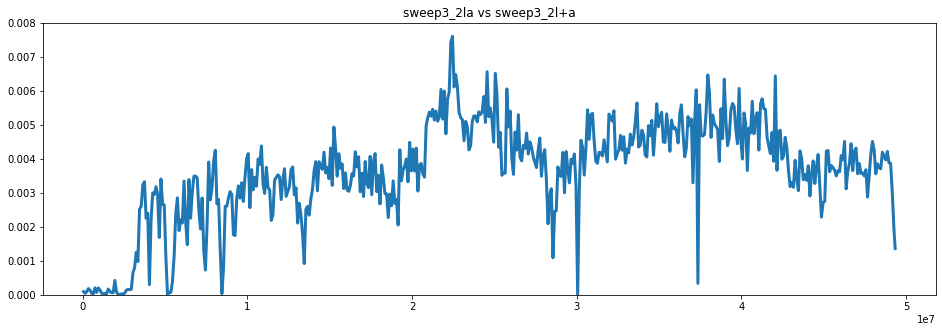

In [253]:
dxy_from_ac(ac_2la, ac_2lplus, pos, size=100_000, title="sweep3_2la vs sweep3_2l+a")

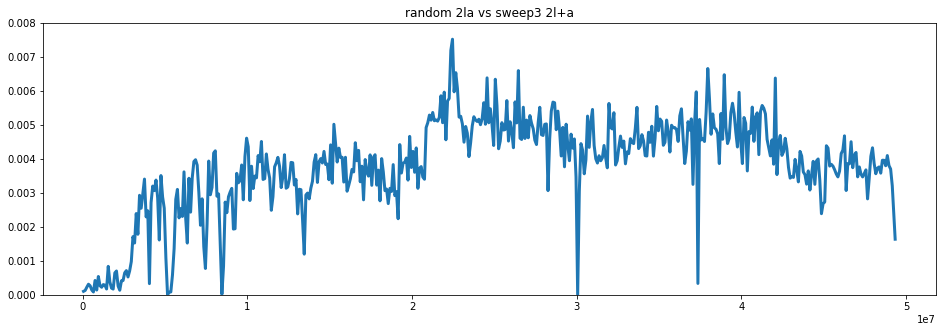

In [254]:
dxy_from_ac(ac_random_2la, ac_2lplus, pos, size=100_000, title="random 2la vs sweep3 2l+a")

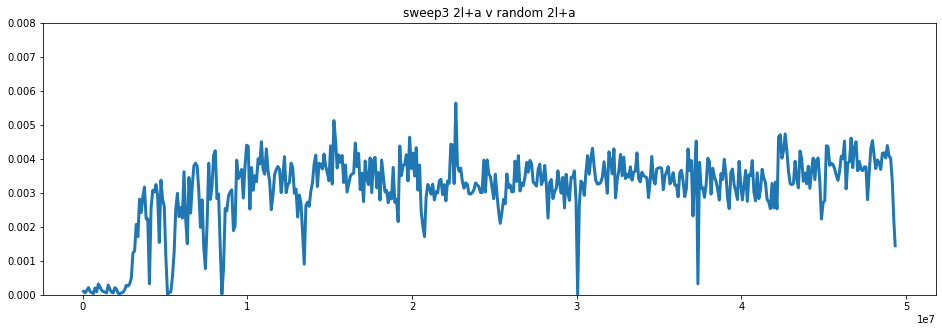

In [255]:
dxy_from_ac(ac_2lplus_random, ac_2lplus, pos, size=100_000, title="sweep3 2l+a v random 2l+a")

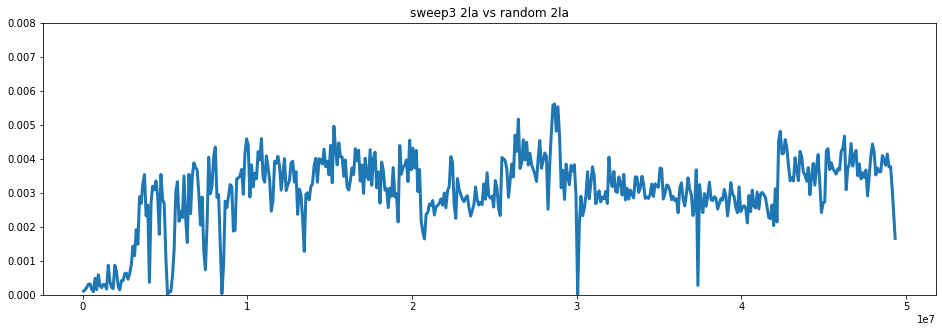

In [257]:
dxy_from_ac(ac_random_2la, ac_2la, pos, size=100_000, title="sweep3 2la vs random 2la")

### Zoom in the region and use smaller window size

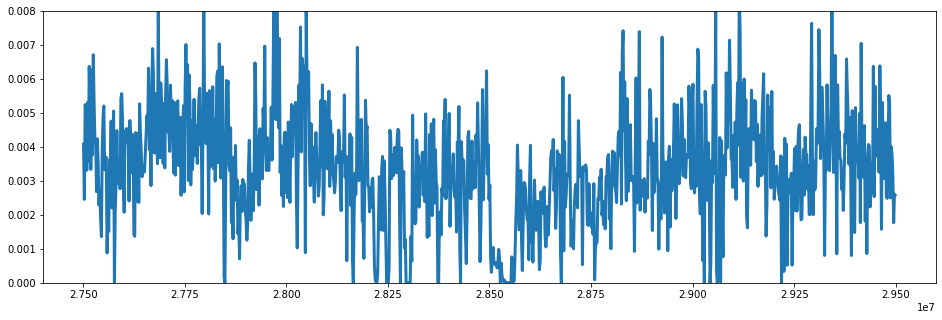

In [237]:
loc_bool = pos.locate_ranges([27_500_000], [29_500_000])

dxy_from_ac(ac_2la.compress(loc_bool, axis=0), ac_2lplus.compress(loc_bool, axis=0), pos[loc_bool], size=2_000)